# Analysis of the sister-city network

## Part 1 : Scraping

We start off by writing a simple scraping algorithm that first yields us all the countries. For the data source we will be following along with the [research paper](https://www.researchgate.net/publication/235356930_Not_All_Paths_Lead_to_Rome_Analysing_the_Network_of_Sister_Cities) and using the wikipedia article which constaints the ["List of towns and sister cities"](https://en.wikipedia.org/wiki/Lists_of_twin_towns_and_sister_cities) for the first steps we can get the list of all continents and then countries.


In [33]:
%matplotlib inline 
from bs4 import BeautifulSoup
from urllib.request import urlopen
PARSER = "html.parser"

url = "https://en.wikipedia.org/wiki/Lists_of_twin_towns_and_sister_cities"

html = urlopen(url).read()
soup = BeautifulSoup(html, PARSER)

continents = soup.find_all("span", {"class": "mw-headline"})
continents = [continent.text.replace(" ", "_") for continent in continents]
print(continents)

countries = soup.find_all("a", href=lambda href: href and href.replace("/wiki/List_of_twin_towns_and_sister_cities_in_", "") not in continents and href.startswith("/wiki/List_of_twin_towns_and_sister_cities_in_"))
print(f"num of countries: {len(countries)}")
cleaned_countries = "\n".join([ country.text.replace("List of twin towns and sister cities in ", "") for country in countries ])
print(cleaned_countries[0:10])

['Africa', 'Asia', 'Australia_and_Oceania', 'Europe', 'North_America', 'South_America']
num of countries: 161
Cape Verde


### 1.1 finding the pattern

Once we have all the countries we can start to see how the html for the actual cities and corresponding sister cities is formatted. While initally I had some confusion as to how to approach this, through testing, I discovered an approach. There was no explicit pattern to link the cities and sister cities so I made use of two ideas

1. Intuitively there should be a section of sister cities for each city
2. We can read read the cities and sister cities independently, so assuming we read the correct order for both we can construct the adjacency list using the `zip` function on both indepdent arrays.

Reading the city sections is rather easy, but making sure we also read the corresponding section for the sister cities required a little more thought. Through some more reading I realized that the tags for the cities has two variants for corresponding tags which contained the sister cities.

1. `p` (city tag) -> `misc tag` -> `div` (which contained a list of sister cities)
2. `p` (city tag) -> `ul` (contains list of sister cities)

So now to read the cities and then corresponding sister cities we just had to read all p tags which either had

-   the `div` as the 2nd element below
-   or `ul` as the first element below

Once this pattern was apparent the rest of the process was just cleaning the data and finding a proper means of storing it, for which I felt a basic dictionairy with the following format was the most appropraite

```
{city -> string : sister_cities -> string[]}
```

Of note here is that the actual city text is nested in the `p` tag, for breviety I just said that the `p` tags correspond to the cities.


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bs4
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

SOURCE_LINK = "https://en.m.wikipedia.org"
PARSER = "html.parser"

sister_cities_dict = dict()

def yield_soup(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, PARSER)
    return soup


def give_nth_below(city, n) -> bs4.element.Tag:
    """Yields yields the nth element below the given element"""
    next = city.parent.find_next_sibling()
    for i in range(n - 1):
        if next:
            next = next.find_next_sibling()
    return next or city


def tag_check(city, sister_cities) -> bool:
    """Checks if tag for city has corresponding section for sister cities"""
    # print value of title attribute of city tag

    first_below = give_nth_below(city.parent, 1)
    second_below = give_nth_below(city.parent, 2)

    if first_below.name == "ul":
        sister_cities.append(first_below)
        return True

    if second_below.name == "div":
        sister_cities.append(second_below)
        return True
    return False


def generate_edges(country_url, country_name):
    country_soup = yield_soup(country_url)

    cities = country_soup.find_all("b")
    sister_cities = []

    # cities list
    cities = map(
        lambda city: "".join(
            [
                f"{city.text}, {country_name}"
                for city in city.find_all("a")
                if (tag_check(city, sister_cities))
            ]
        ),
        cities,
    )
    cities = list(
        filter(lambda city: city != "" and city != "" and city != "^", cities)
    )

    # sister_cities list for corresponding cities
    sister_city_list = list(
        map(
            lambda sister_city: [
                ", ".join(
                    [  # joining array back after cleaning
                        word.lstrip().rstrip()  # remove leading and trailing spaces
                        for word in re.sub(  # removing citation
                            r"\[\d+\]",
                            "",
                            (
                                sister_city.parent.text
                            ).replace(  # remove non-breaking space
                                "\xa0", ""
                            ),
                        ).split(
                            ","
                        )  # splitting to clean individual words
                    ]
                )
                for sister_city in sister_city.find_all(
                    "a", href=lambda href: href and not href.startswith("#cite_note")
                )
                if sister_city.parent.name != "span"
            ],
            sister_cities,
        )
    )

    adj_list = dict(zip(cities, sister_city_list))
    sister_cities_dict.update(adj_list)


for country in countries[0:10]:
    country_url = SOURCE_LINK + country["href"]
    country_name = country["href"].replace("/wiki/List_of_twin_towns_and_sister_cities_in_", "")
    if(len(pd.read_csv("assets/adj_list.csv")) > 0):
        break
    
    generate_edges(country_url, country_name.replace("_", " "))

dataframe = pd.DataFrame.from_dict(sister_cities_dict, orient="index")
dataframe.to_csv(r"assets/adj_list.csv")

### 1.2 writing and reading

#### writing

Since we don't want to scrape the data each time, especially once we start to work with a larger dataset, it makes sense to save the data. Since our datastructure is rather simple we could just write to it manually, using an approach like the following

```python
with open('dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in mydict.items():
       writer.writerow([key, value])
```

But using dataframes from the `pandas` we can make this process a bit cleaner by just create a dataframe from the dictionary, orienting it by `index` and then writing it all to a csv.

#### reading

To read the data back all we need to do is use the `read_csv` function. After which we can reconstruct the original dictionary we used to hold the cities and sister cities. Then from this dictionary we can create our graph.


In [30]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import pprint
from typing import Tuple

def generate_graph(size) -> Tuple[nx.Graph, dict]:
    G = nx.Graph()
    
    csv_data = pd.read_csv(r"assets/adj_list.csv").to_numpy().tolist()

    # reconstructing the adjacency list from csv
    graph_adj_list = dict()

    for row in csv_data:
        key = row[0]
        value = list(filter(lambda item: str(item) != "nan", row[1 : len(row)]))
        graph_adj_list[key] = value

    graph_adj_list = dict(itertools.islice(graph_adj_list.items(), size))
    for key, value in graph_adj_list.items():
        for item in value:
            G.add_edge(key, item)

    return (G, graph_adj_list)

G, adj_list = generate_graph(100)

print(f"number of edges: {G.number_of_edges()}")

number of edges: 387


## Part 2 : Displaying

Now if we just use the basic layout for drawing networks then there is alot of overlap with the nodes which makes everything quite unreadable.


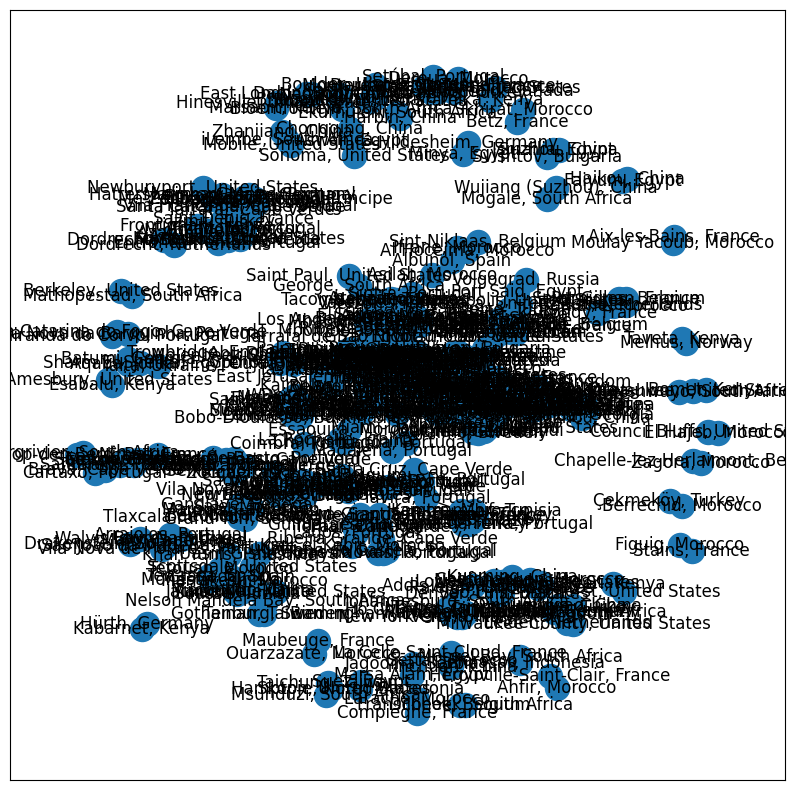

In [32]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=True)
plt.show()

So the first observation should be that the nodes are too close together. Also the text overflows the nodes quite heavily. Furhtermore the different components of the graph are scattered quite sporadically. So to fix this we can address each issue step by step.

#### issue 1 - Nodes too close

To solve the nodes being to close we can use the spring layout. Which quoting the documentation :

```
... simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force
```

The important parameter here is `k` which as it increases moves nodes further apart from oneanother. I could not figure out any nice way to find a nice value besides brute force so after a little bit of testing I settled on $20\times \displaystyle\frac{1}{\sqrt{\text{number of nodes}}}$

#### issue 2 - Node sizes

Clearly we want the nodes to cover a larger portion of the word to make it look less awkward, to do this we can simply increase the `node_size` argument and maybe also change the color of the nodes and edges to something more pastel to give the graph a less harsh appearance.


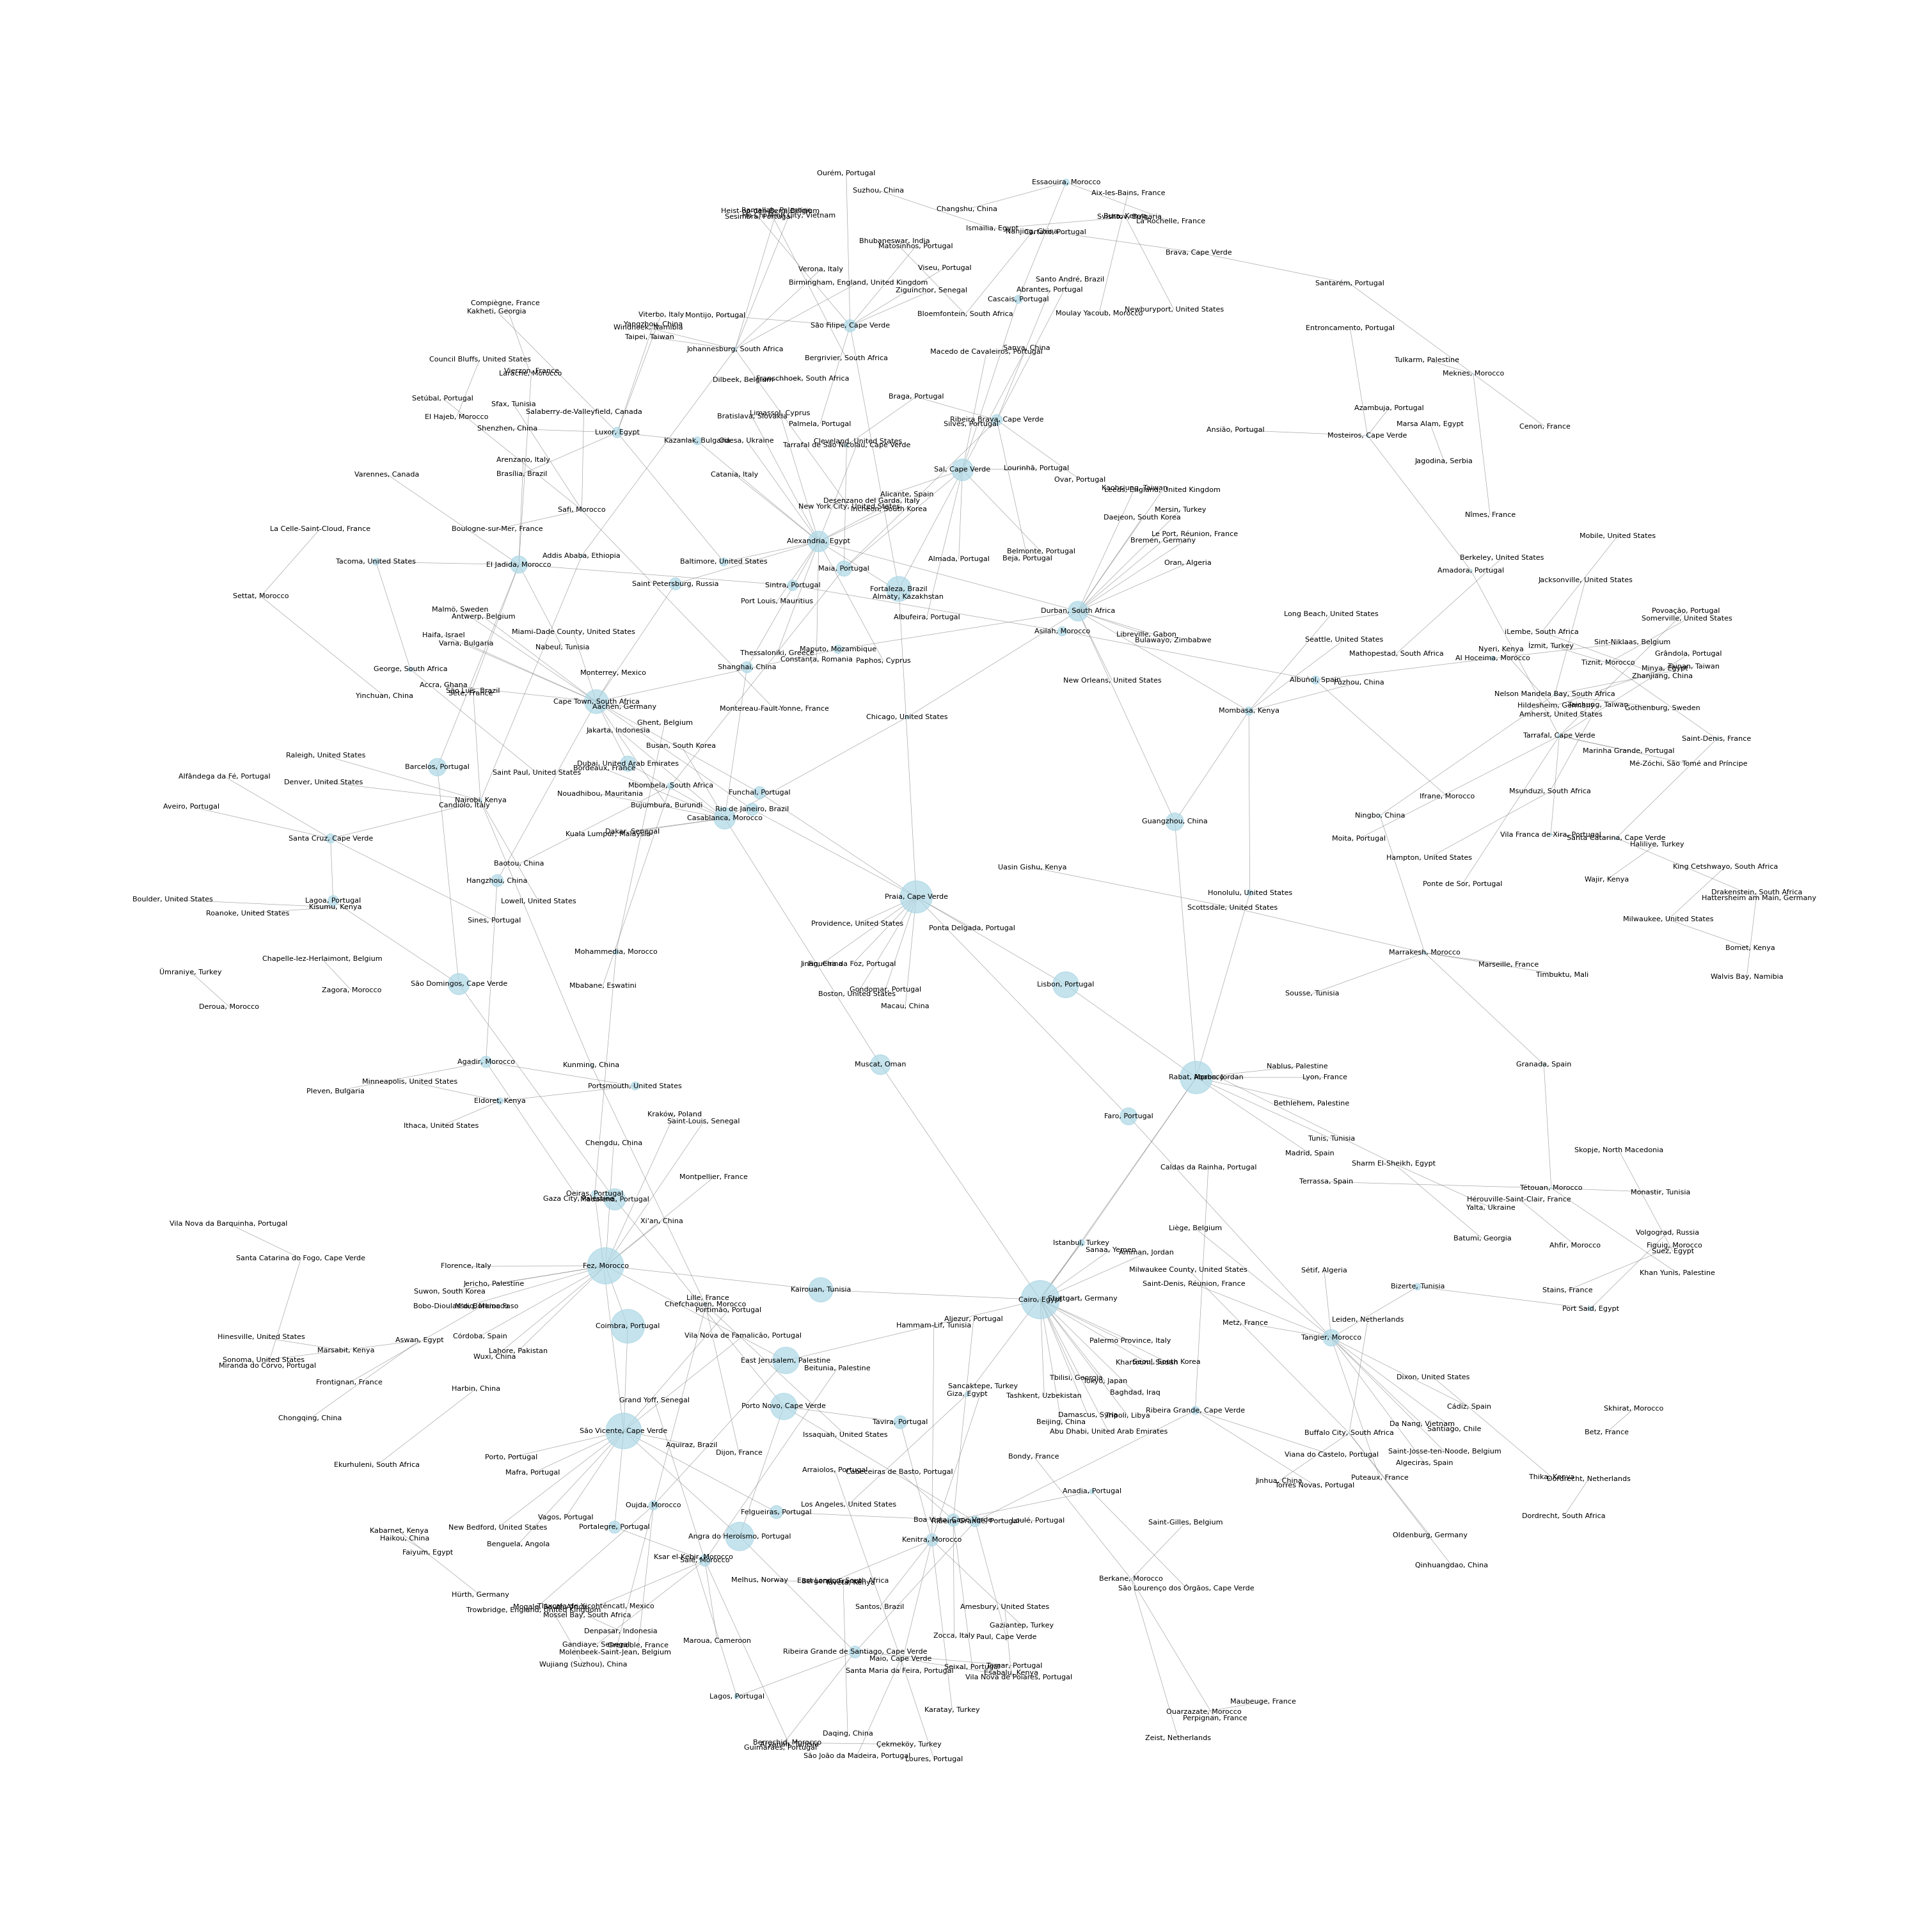

In [31]:
# controls the graph layout
pos = nx.spring_layout(
    G,
    k=20 * 1 / np.sqrt(len(G.nodes())),
    iterations=400,
    scale=1000,
)

plt.figure(figsize=(30, 30))

node_betweeness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, node_betweeness, "betweeness")

# draw nodes and edges
nx.draw(
    G,
    pos=pos,
    node_size=[v * 10000 for v in node_betweeness.values()],
    node_color="lightblue",
    edge_color="gray",
    alpha=0.7,
    width=0.5,
)

nx.draw_networkx_labels(G, pos=pos, font_size=8)
plt.axis("off")
plt.savefig("assets/graph.svg", transparent=True)
plt.show()

### 2.1 improving the display using pyvis

One of the most prominant issues which is still apparent is that nodes still overlap to the point where it makes certain labels illegible. Here we could play around a bit more networkx but pyviz, which can interface with networkx, might be better suited moving forwards.


In [ ]:
from pyvis.network import Network

net = Network(
    notebook=True,
    height="1000px",
    width="1000px",
    bgcolor="#222222",
    font_color="white",
    cdn_resources="remote",
)
net.from_nx(G)
net.save_graph("assets/basic_example.html")

This is alot nicer, now lets see scrape a few more cities and then see what our graph looks like. To improve the performance we can disable dragging of the nodes using the `toggle_drag_nodes(false)`


In [ ]:
SOURCE_LINK = "https://en.m.wikipedia.org"

for country in countries:
    country_url = SOURCE_LINK + country["href"]
    if len(G) < 100:
        country_name = country["href"].replace("/wiki/List_of_twin_towns_and_sister_cities_in_", "")
        generate_edges(country_url, country_name.replace("_", " "))

In [ ]:
net = Network(
    notebook=True,
    height="1000px",
    width="1000px",
    bgcolor="#222222",
    font_color="white",
)
net.from_nx(G)
net.save_graph("assets/more_cities.html")

### 2.2 further refinements

One final change I think would improve the visualization would be to make the degree centrality of a node correspond to its size and to introduce some community clustering.


In [ ]:
from community import community_louvain

net = Network(
    notebook=True,
    height="1000px",
    width="100%",
    bgcolor="#222222",
    font_color="white",
    select_menu=True,
    cdn_resources="remote",
)

node_degree = dict(G.degree)
node_betweeness = nx.betweenness_centrality(G)
node_closeness = nx.closeness_centrality(G)
node_community = community_louvain.best_partition(G)

nx.set_node_attributes(G, node_degree, "degree")
nx.set_node_attributes(G, node_betweeness, "betweeness")
nx.set_node_attributes(G, node_closeness, "closeness")
nx.set_node_attributes(G, node_community, "group")

net.from_nx(G)
net.save_graph("assets/all_cities.html")

## Part 3: Analysis

One of the first things I thought would be cool to see would be the network of the sister cities visualized ontop of the worldmap. Similar to the following [image](https://www.researchgate.net/figure/Connections-between-sister-cities-visualised-on-a-world-map-Shorter-connections-are_fig2_235356930) but at a higher resolution.
Breaking this problem down :

1. I need to get some high resolution image of the world map, something which would hopefully not degrade too much in quality with zooming.
2. I would somehow need to correspond each node representing a city with its coordinate on the world map.
3. Once I have that I should in theory just be able to render the graph based off the edges I already have stored.


### 3.1 Rendering the image

So the first thing that comes to mind with "high resolution that doesnt degrade in quality with scaling" is obviously svg, so now the challanges becomes how do we actually display the svg then how do we have the network overlay the svg.
Matplotlib can apparently display images and also interface with networkx so lets give that a go.


In [27]:
import svgutils.compose as sc
from IPython.display import SVG

svg_path = "assets/world.svg"
fig, ax = plt.subplots(figsize=(4, 4))

fig.savefig("assets/cover.svg", transparent=True)
plt.close(fig)

# Here starts the assembling using svgutils
sc.Figure(
    "20cm",
    "10cm",
    sc.SVG("assets/world.svg").scale(0.01),
    sc.SVG("assets/graph.svg").scale(0.0025).move(1, 1),
).save("assets/compose.svg")

SVG("assets/compose.svg")

Well, now that worked, but it doesn't really look quite right, and it getting this to work would probably end up being quite finnickey. Its probably better to use the existing mapping library called `Basemap` which might be better suieted to our purposes. So trying that out.


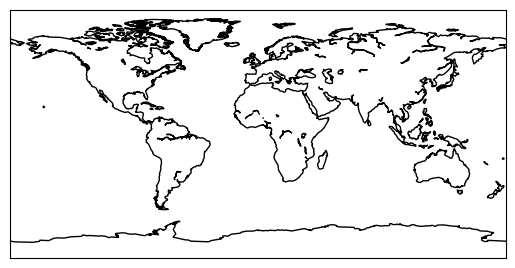

<Figure size 640x480 with 0 Axes>

In [26]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap()

map.drawcoastlines()

plt.show()
plt.savefig("assets/basic_map.png")

This works but lets improve some parameters both to make it larger and improve the resolution of things to have a nice base onto which we can project all of out points.


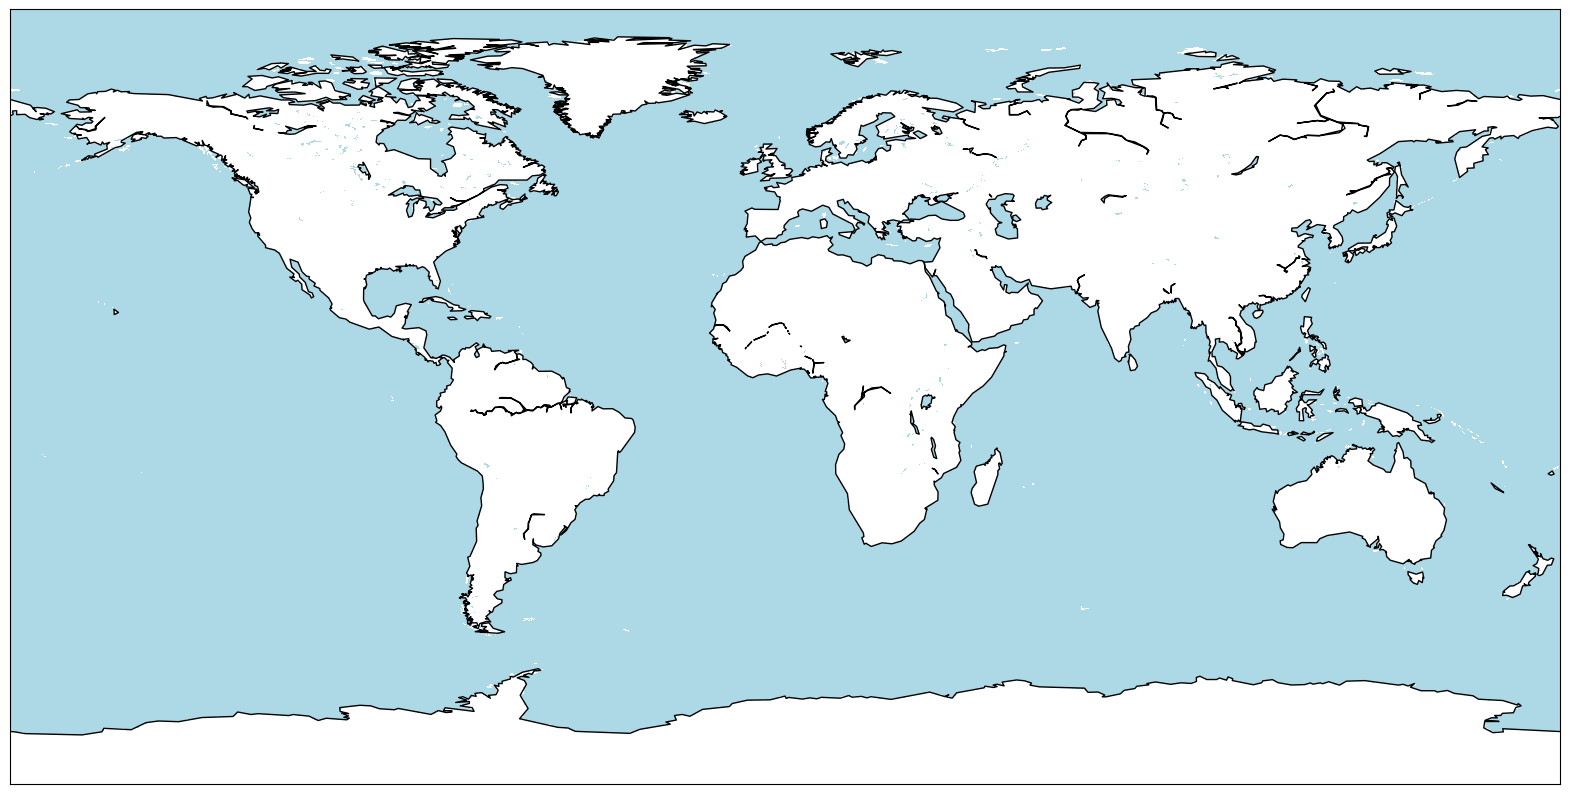

In [25]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# display basemap of entire world, land is white and water is light blue
m = Basemap(lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawlsmask(land_color="white", ocean_color="lightblue", lakes=True)
# increase the size and dpi of the map
plt.gcf().set_size_inches(20, 20)

### 3.2 Mapping the city nodes to coordinates

#### reading coordinates
This might be a bit harder. So in practice what this means is that for each node we need some $(x, y)$ coordinate corresponding to its real world coordinates. That is, we need to translate all real world coordinates to the 2D coordinate plane. To break this down into steps the first thing we need is to construct a list of cities with their associated lat/lon position.

Luckily the basemap library has some tools to make this process not too difficult.


In [24]:
df = pd.read_csv("assets/worldcities.csv")
city_list = list(G.nodes())

world_cities = dict()

for index, row in df.iterrows():
    lons, lats = m(row["lng"], row["lat"])
    world_cities[", ".join([row["city"], row["country"]])] = [lons, lats]

# example output for the first two mappings
pprint.pprint(dict(itertools.islice(world_cities.items(), 2)))

{'Jakarta, Indonesia': [106.8275, -6.175], 'Tokyo, Japan': [139.6922, 35.6897]}


#### graphing process
To then actually put everything together we can break it down into a step by step process
 
**Setup**

To setup we generate the graph which we want to overlay on the map and we generate the map itself which will be the basis.

**Cleaning**

No because there are some discrepancies in the naming conventions between the cities in my dataset and the world cities (which maps cities to coordinates) for simplicity sake we simply exclude any nodes which don't map to some corresponding location.

**Graphing**

The final graphing process is mostly straightforward. The nodes we graph as usual using our world_cities dictionary for the position data so nodes align with thier cities. Then for the edges we can either use the edges from the graph directly which would just yield straight lines or we can use the `drawgreatcircle` method which draws the edges in a manner reflecting the real world distance.

number of cities in graph: 578


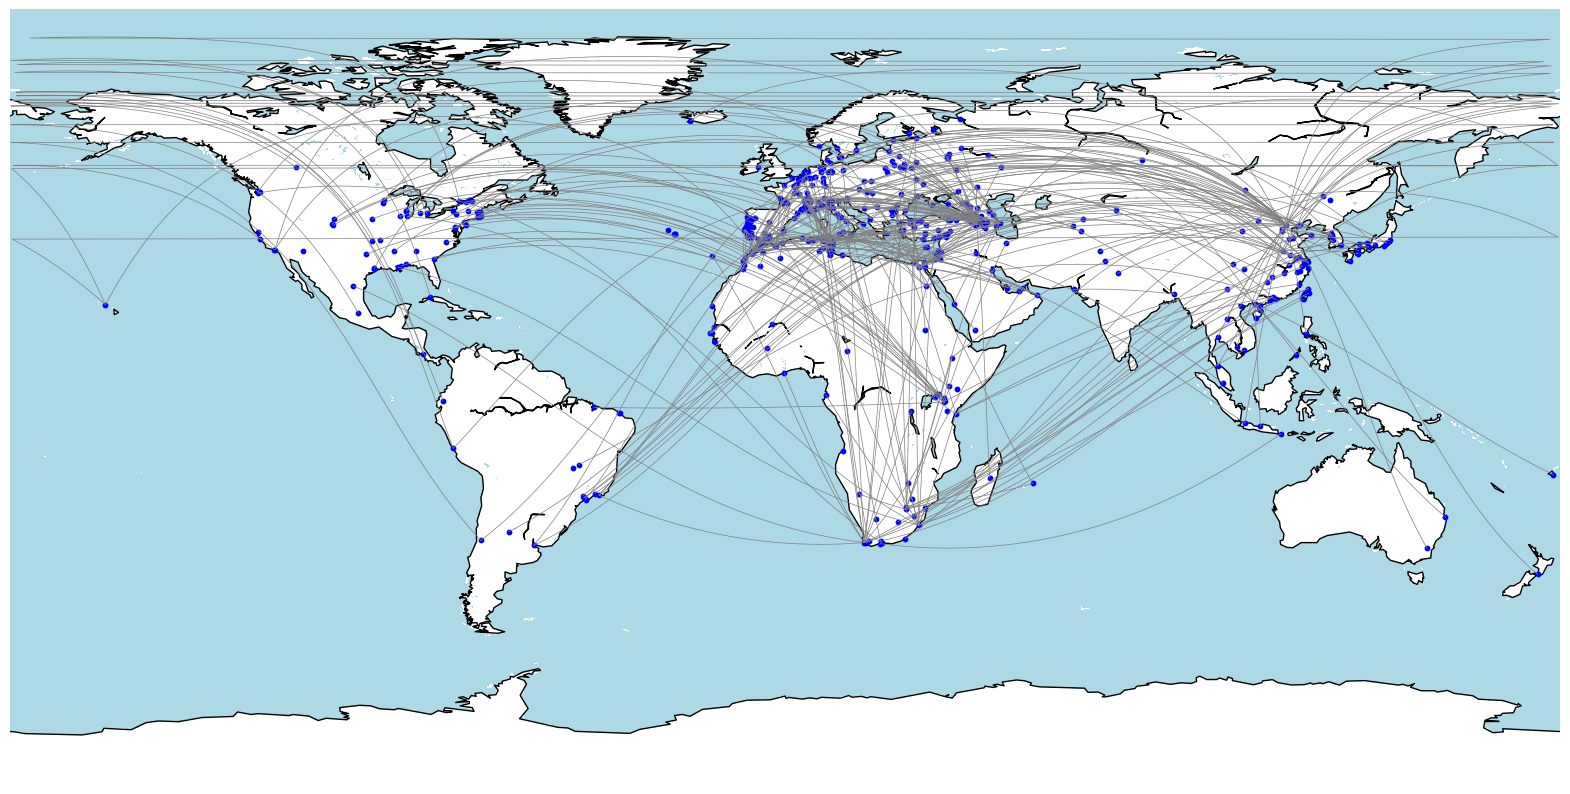

In [21]:
import pandas as pd

G, adj_list = generate_graph(200)

m = Basemap(lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawlsmask(land_color="white", ocean_color="lightblue", lakes=True)
# increase the size and dpi of the map
plt.gcf().set_size_inches(20, 20)

# remove all nodes who dont have an entry in world_cities
G.remove_nodes_from([node for node in G.nodes() if node not in world_cities.keys()])

print(f"number of cities in graph: {len(G)}")

node_betweeness = nx.betweenness_centrality(G)

# print edges of G
nx.draw(
    G,
    pos=world_cities,
    node_size=10,
    node_color="blue",
    edge_color="gray",
    alpha=1,
    width=0,
)

for edge in G.edges():
    # print(edge)
    x = [world_cities[edge[0]][0], world_cities[edge[1]][0]]
    y = [world_cities[edge[0]][1], world_cities[edge[1]][1]]
    m.drawgreatcircle(x[0], y[0], x[1], y[1], linewidth=0.5, color="gray")
    
plt.show()